<h2> More analysis</h2>
<p> In the previous notebook, we did some data munging, model selection, hyperparameter optimization and community analysis. In this notebook, we'll do a bit more analysis and also apply LDA to range estimation and species distribution modeling.</p>

In [1]:
from collections import Counter
from csv import reader
import descartes
import fiona
import gensim
from geopandas import GeoDataFrame
import geopy
from IPython.display import Image,display
import flandersmap as fm
import logging
import matplotlib.pyplot as plt
from mpl_toolkits import basemap
import mpl_toolkits
import numpy as np
import pandas as pd
import pickle
from pprint import pprint
import pyper as pr
import seaborn as sns
import shapely
from sklearn.cluster import SpectralClustering
from sklearn.metrics import roc_auc_score
import sys
import wrappers as w


%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


/home/chris/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# First, we'll load the dataframes we were using before:

speciesCommunityDF = pd.read_csv('dataframes/speciesCommunityDF.csv',index_col='Unnamed: 0')
communityLocationDF = pd.read_csv('dataframes/communityLocationDF.csv',index_col = 'verbatimCoordinates')
presenceDF = pd.read_csv('dataframes/presenceDF.csv',index_col = 'Unnamed: 0')


<h2> Another round of clustering</h2>
<p> We've got spatial maps of community prominence over the landscape, but what we'd really like to know is which physical locations are similar to each other with regard to the distribution over all communities! One way to do this is by clustering the physical locations by their distributions over communities. Then, the cluster labels should group together locations which have similar makeup of communities. We'll use the spectral clustering [implementation] in sklearn. This will give us a feel for which regions have similar makeups, i.e. in which the mixture proportions of communities are similar. </p>

NameError: global name 'lowerLeftCornerLatitude' is not defined

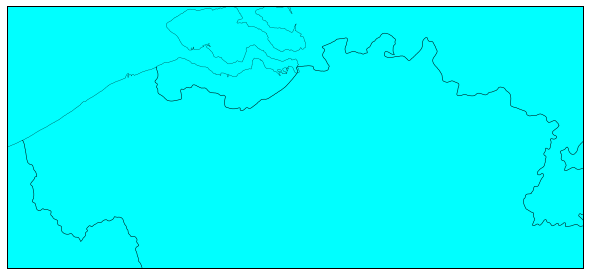

In [7]:
theta = communityLocationDF.drop(['decimalLatitude','decimalLongitude'],1)
assert theta.shape[0] > theta.shape[1]  

lowerLeftCornerLongitude  = min([float(i) for i in communityLocationDF['decimalLongitude'].values])-.1
lowerLeftCornerLatitude   = min([float(i) for i in communityLocationDF['decimalLatitude'].values])-.1
upperRightCornerLongitude = max([float(i) for i in communityLocationDF['decimalLongitude'].values])+.1
upperRightCornerLatitude  = max([float(i) for i in communityLocationDF['decimalLatitude'].values])+.1

x = [float(i) for i in communityLocationDF['decimalLongitude'].values]
y = [float(i) for i in communityLocationDF['decimalLatitude'].values]

bmap = w.basemapWrapper(lowerLeftCornerLongitude,lowerLeftCornerLatitude,upperRightCornerLongitude,upperRightCornerLatitude)

'''sc = SpectralClustering(n_clusters = 12)
clusterLabels = sc.fit_predict(theta)
bmap.scatter(x,y,latlon=True,s=4,c=clusterLabels,edgecolor='',cmap='Set2_r')'''


In [ ]:
_ = plt.title('Spectral clustering by community makeup',fontsize=20)

<h2> Distribution modeling</h2>
<p> Now we'll go ahead and try a predictive model of species distribution. This model will have two components - a prior probability of ANY species occurring and a likelihood that if a new species were to be observed, that it would be the species that we're interested in. We'll try a couple different types of priors to see which ones give the best performance.</p>

<h3> Selecting species to model</h3>
<p> We would like to test this model on species which have varying rates of occurrence in the test area. To do this, we will sort the species by the number of plot locations in which they are observed and then select on this basis. </p>

In [14]:
prevalences = np.sum(presenceDF.values,axis=0)
reversedIndices = np.argsort(prevalences)
indices = reversedIndices[::-1]
modeledSpecies = indices[0:20]

<h3> Modeling with different subsets of observations</h3>

In [15]:
estimatesDict={}
aucDict={}
trainFractions = [0.01,0.1,0.25,0.5]
replicates = 1

for species in modeledSpecies:
    for fraction in trainFractions:
        for prior_type in ['tanh']:
            for replicate in range(0,replicates):
                splitData,newSpeciesIndex = w.knockoutData(presenceDF.values,replicate,species, percentObservationsKept=fraction)
                estimatesDict[(species,fraction,prior_type,replicate)] = w.sdm(splitData,22,newSpeciesIndex,prior_type=prior_type)
                aucDict[(species,fraction,prior_type,replicate)]= roc_auc_score((presenceDF.values)[:,species].astype(int), estimatesDict[(species,fraction,prior_type,replicate)])
            
pprint(aucDict)

{(12, 0.01, 'tanh', 0): 0.72392122922535662,
 (12, 0.1, 'tanh', 0): 0.65572070338543909,
 (12, 0.25, 'tanh', 0): 0.63779994846251187,
 (12, 0.5, 'tanh', 0): 0.67294277650903289,
 (169, 0.01, 'tanh', 0): 0.77149397418952514,
 (169, 0.1, 'tanh', 0): 0.78807370853515213,
 (169, 0.25, 'tanh', 0): 0.78789570302247214,
 (169, 0.5, 'tanh', 0): 0.76742257675343795,
 (350, 0.01, 'tanh', 0): 0.72879527456032533,
 (350, 0.1, 'tanh', 0): 0.79571083519374941,
 (350, 0.25, 'tanh', 0): 0.74210616528324513,
 (350, 0.5, 'tanh', 0): 0.74418492913591872,
 (461, 0.01, 'tanh', 0): 0.66850854481854083,
 (461, 0.1, 'tanh', 0): 0.63326516505422747,
 (461, 0.25, 'tanh', 0): 0.63753770398296272,
 (461, 0.5, 'tanh', 0): 0.68316152658842944,
 (518, 0.01, 'tanh', 0): 0.6684484970807909,
 (518, 0.1, 'tanh', 0): 0.70635654860951425,
 (518, 0.25, 'tanh', 0): 0.69339208347417969,
 (518, 0.5, 'tanh', 0): 0.68902324031553441,
 (646, 0.01, 'tanh', 0): 0.68415597786925464,
 (646, 0.1, 'tanh', 0): 0.70735511060688139,
 (64

In [13]:
aucDict

{(12, 0.01, 'linear', 0): 0.50005827505827505,
 (12, 0.01, 'tanh', 0): 0.66994600660422532,
 (12, 0.01, 'uniform', 0): 0.68718435398377475,
 (12, 0.1, 'linear', 0): 0.50005827505827505,
 (12, 0.1, 'tanh', 0): 0.69762464785998457,
 (12, 0.1, 'uniform', 0): 0.63074316664106667,
 (12, 0.25, 'linear', 0): 0.50005827505827505,
 (12, 0.25, 'tanh', 0): 0.67640646424136652,
 (12, 0.25, 'uniform', 0): 0.67773967323207007,
 (12, 0.5, 'linear', 0): 0.50005827505827505,
 (12, 0.5, 'tanh', 0): 0.64771462747567021,
 (12, 0.5, 'uniform', 0): 0.61900795117666951,
 (518, 0.01, 'linear', 0): 0.50005791058605509,
 (518, 0.01, 'tanh', 0): 0.73411820942790573,
 (518, 0.01, 'uniform', 0): 0.66236369343605817,
 (518, 0.1, 'linear', 0): 0.50005791058605509,
 (518, 0.1, 'tanh', 0): 0.70946716425866829,
 (518, 0.1, 'uniform', 0): 0.69217783062101046,
 (518, 0.25, 'linear', 0): 0.50005791058605509,
 (518, 0.25, 'tanh', 0): 0.70119745042732029,
 (518, 0.25, 'uniform', 0): 0.71957487709897916,
 (518, 0.5, 'linear'

In [11]:
modeledSpecies

array([2146, 1659,  518,   12, 2118])

<h3> Evaluating with AUC</h3>

In [8]:
estimatesDict

{(2146,
  0.01,
  'uniform',
  0): array([ 0.00913866,  0.00578396,  0.00501804, ...,  0.00839813,
         0.00781071,  0.0117951 ])}

<h3> Making maps of suitability</h3>

{(57, 0.01, 0): 0.66506051626607143,
 (523, 0.01, 0): 0.70357832636749218,
 (1509, 0.01, 0): 0.5566459325423615,
 (1874, 0.01, 0): 0.62908926592906012,
 (2146, 0.01, 0): 0.57137462748611301}


<h3> Comparing against maximum entropy method</h3>